# Data Analysis

## Spark + MongoDB

In [4]:
from pyspark.sql import SparkSession
from operator import add
import re
import random

In [ ]:
#--conf spark.jars.ivy=

In [5]:
def sort_1(e):
    return e[0]

def sort_2(e):
    return e[1]

## Build a SparkSession
Build a spark session that connects to master and mongodb database

In [33]:
spark = SparkSession.builder\
    .appName("Data_analysis_final")\
    .master("spark://172.20.0.2:7077") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.1.1")\
    .config("spark.mongodb.read.connection.uri", "mongodb://192.168.2.6:27117/MSS.songs")\
    .getOrCreate()
    
spark_context = spark.sparkContext

#### Read the million song dataset data from our mongodb

In [35]:
sdf = spark\
.read\
.option("packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.1.1")\
.option("uri", "mongodb://192.168.2.6:27117/MSS.songs")\
.format("mongodb").load()

In [8]:
sdf.show()

23/03/22 13:15:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+----------------+-----------------+-------------------+-------------------+--------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+--------------------+------------+---------+--------------+------+-----+-----------------+----------------+-------------------+--------------+--------------------+---------------+-----------------------+------------------+-----------------------+-------------------------+------------------------------+---------------------------+--------------------+------------------+-------------------+-------------------+---------------------+----------------+---+--------------+--------+----+---------------+--------------------+------------------+-------------------+--------------------+-----------------+-------+--------------+-------------------------+--------------------+----------------+--------------------+----+
|                 _id|analysis_sample

In [17]:
#spark.stop()

## The data analysis
We have chosen to analyse what is the most common words in song titles and how it correlates to the hottest songs

In [9]:
# A function to only get the letters and numbers of the song titles
def removearticles(text):
    return re.findall('[a-zA-Z0-9]+', text)

In [10]:
sdf.select('title', 'song_hotttnesss').schema

StructType([StructField('title', StringType(), True), StructField('song_hotttnesss', StringType(), True)])

In [45]:
# select -> rdd
out = sdf.select('title', 'song_hotttnesss').rdd
# replace nan with 0; split words in wordlists;
out2 = out.map(lambda x: (removearticles(x[0][2:-1]), float(x[1]) if x[1] != 'nan' else 0.5)) 
# 
out3_h = out2.flatMap(lambda x: [(i, x[1]) for i in x[0]])
# 
out3_c = out2.flatMap(lambda x: [(i, 1) for i in x[0]])
#
out4_h = out3_h.reduceByKey(add).collect()
#
out4_c = out3_c.reduceByKey(add).collect()
#
c_sort = sorted(out4_c, key=sort_2, reverse=True)
#
h_sort = sorted(out4_h, key=sort_2, reverse=True)
#
all_sort = [(i[0], j[1]/i[1]) for i, j in zip(c_sort, h_sort)]

### The result:

In [46]:
sorted(all_sort, key=sort_2, reverse=True)

[('Sarank', 0.6320809374994478),
 ('xa9gni', 0.6316008180888096),
 ('Rainin', 0.6313903653184915),
 ('Balao', 0.6310080588180911),
 ('Preta', 0.6294767326751742),
 ('Pretinha', 0.6292127100645375),
 ('Juazeiro', 0.6290718355952272),
 ('Foam', 0.6282179645794025),
 ('Backtrack', 0.6281250584184764),
 ('Swim', 0.6274948536700506),
 ('Actress', 0.6273634475759199),
 ('Channels', 0.6273634475759199),
 ('Cami', 0.6272025955607587),
 ('fait', 0.6270737964039372),
 ('xa9j', 0.6269085853787749),
 ('Quiser', 0.6266128026956008),
 ('Parasitic', 0.6266128026956008),
 ('Twins', 0.6266128026956008),
 ('pasta', 0.6265859803064825),
 ('fagioli', 0.626520938818931),
 ('Tucker', 0.6264642401853926),
 ('Sanddollars', 0.6261657596688281),
 ('Cutting', 0.6259317127151359),
 ('Motel', 0.625865454009952),
 ('Akhan', 0.6254115257921741),
 ('Nay', 0.6249533671840265),
 ('Sharab', 0.6248397909779997),
 ('Leading', 0.6248397909779997),
 ('Str8', 0.6248335335556564),
 ('Lurkin', 0.6247461105191231),
 ('Huo', 0.6

In [ ]:
spark.stop()

## Tests for scalability



In [2]:
def removearticles(text):
    return re.findall('[a-zA-Z0-9]+', text)

def data_analyze(sdf):
    # select -> rdd
    out = sdf.select('title', 'song_hotttnesss').rdd
    # replace nan with 0; split words in wordlists;
    out2 = out.map(lambda x: (removearticles(x[0][2:-1]), float(x[1]) if x[1] != 'nan' else random.random())) 
    # 
    out3_h = out2.flatMap(lambda x: [(i, x[1]) for i in x[0]])
    # 
    out3_c = out2.flatMap(lambda x: [(i, 1) for i in x[0]])
    #
    out4_h = out3_h.reduceByKey(add).collect()
    #
    out4_c = out3_c.reduceByKey(add).collect()
    #
    c_sort = sorted(out4_c, key=sort_2, reverse=True)
    #
    h_sort = sorted(out4_h, key=sort_2, reverse=True)
    #
    all_sort = [(i[0], j[1]/i[1]) for i, j in zip(c_sort, h_sort)]

In [8]:
import time
# set the the masternode here
master = "spark://172.20.0.2:7077"

# set the desired number of cores
num_cores = [i for i in range(1, 10)]
time_dct = {}
col = ['tsession_created', 'tdata_loaded', 'tdata_analyzed']
tanalysis = []

for ncs in num_cores:
    time_lst = []
    time_start = time.time() # tstart
    spark = SparkSession.builder\
                        .appName("analysis_test_0_cores_{}".format(ncs))\
                        .master(master) \
                        .config("spark.cores.max", ncs)\
                        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.1.1")\
                        .config("spark.mongodb.read.connection.uri", "mongodb://192.168.2.6:27117/MSS.songs")\
                        .config("spark.executor.memory", "1536m")\
                        .getOrCreate()
    time_lst.append(time.time() - time_start) # tsession_created
    sdf = spark\
                        .read.format("mongodb")\
                        .option("uri", "mongodb://192.168.2.6:27117/MSS.songs").load()
    time_lst.append(time.time() - time_start) # tdata_loaded
    
    # data analysis
    data_analyze(sdf)
    tanalysis.append(time.time() - time_start - time_lst[-1])

    time_lst.append(time.time() - time_start) # tdata_analysed
    
    #.config("spark.executor.resource.cores.amount", "2")\
    #.config("spark.executor.memory", "1024m")\
    
    spark.stop()
    time_dct[str(ncs)] = time_lst


In [13]:
print(col)
for i, j in time_dct.items():
    print(i, j)

['tsession_created', 'tdata_loaded', 'tdata_analyzed']
1 [0.2158493995666504, 0.4444558620452881, 11.443721771240234]
2 [0.2306351661682129, 0.48070597648620605, 10.972207069396973]
3 [0.2234025001525879, 0.4620218276977539, 16.44018054008484]
4 [0.26425862312316895, 0.5065231323242188, 16.459416389465332]
5 [0.23223137855529785, 0.48665595054626465, 11.1043381690979]
6 [0.23418354988098145, 0.5155808925628662, 16.563082218170166]
7 [0.23644328117370605, 0.5092132091522217, 11.229939937591553]
8 [0.22928500175476074, 0.47965192794799805, 16.312576055526733]
9 [0.21239256858825684, 0.4831571578979492, 16.216747283935547]


In [9]:
time_dct

{'1': [0.23832249641418457, 0.6472771167755127, 11.54476284980774],
 '2': [0.27153992652893066, 0.5261650085449219, 16.470545053482056],
 '3': [0.2578885555267334, 0.5282704830169678, 17.916645526885986],
 '4': [0.24032044410705566, 0.5095505714416504, 16.345747470855713],
 '5': [0.24989056587219238, 0.5090103149414062, 16.383748769760132],
 '6': [0.25486063957214355, 0.5290610790252686, 16.446305513381958],
 '7': [0.22277021408081055, 0.483745813369751, 17.109148263931274],
 '8': [0.23294448852539062, 0.5155680179595947, 16.233439922332764],
 '9': [0.21246099472045898, 0.4880819320678711, 15.72444486618042]}

In [10]:
tanalysis

[10.897473812103271,
 15.944377660751343,
 17.38837218284607,
 15.836193799972534,
 15.874735116958618,
 15.917242288589478,
 16.625399827957153,
 15.717868566513062,
 15.23635983467102]

In [31]:
spark.stop()

## Plots

In [2]:
# In case matplotlib is not installed:
# ! pip3 install matplotlib

In [47]:
result = sorted(all_sort, key=sort_2, reverse=True)
result[:10]

[('Sarank', 0.6320809374994478),
 ('xa9gni', 0.6316008180888096),
 ('Rainin', 0.6313903653184915),
 ('Balao', 0.6310080588180911),
 ('Preta', 0.6294767326751742),
 ('Pretinha', 0.6292127100645375),
 ('Juazeiro', 0.6290718355952272),
 ('Foam', 0.6282179645794025),
 ('Backtrack', 0.6281250584184764),
 ('Swim', 0.6274948536700506)]

#### Plot songs per year

Text(0, 0.5, 'Nr of songs')

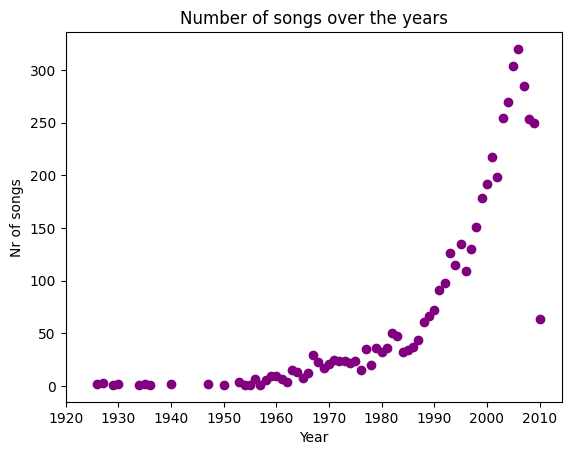

In [48]:
import matplotlib.pyplot as plt

year_freq = sdf.select('Year').rdd\
                .map(lambda x: (x, 1))\
                .reduceByKey(add).collect()
years = [float(i[0][0]) if float(i[0][0])>0 else None for i in year_freq]
years_freq_ =[i[1] for i in year_freq]

plt.plot(years, years_freq_,'o', color='purple')
plt.xticks(range(1920, 2012, 10))
plt.title('Number of songs over the years')
plt.xlabel('Year')
plt.ylabel('Nr of songs')

#### Plot song per year with condition

Text(0, 0.5, 'Nr of songs')

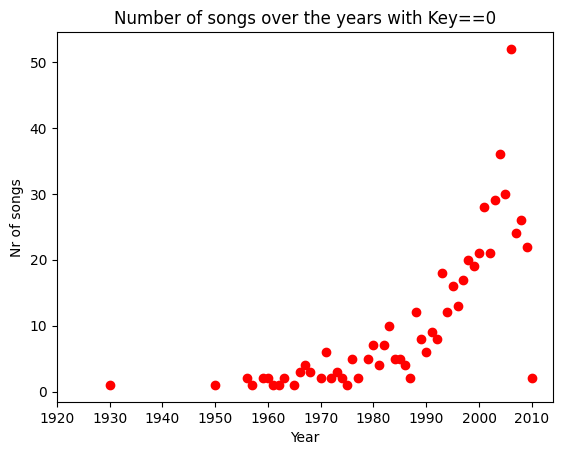

In [49]:
condition = 'Key==0'
year_freq = sdf.where(condition).select('Year').rdd\
                .map(lambda x: (x, 1))\
                .reduceByKey(add).collect()#, key=sort_1, reverse=False)
years = [float(i[0][0]) if float(i[0][0])>0 else None for i in year_freq]
years_freq_ =[i[1] for i in year_freq]

plt.plot(years, years_freq_,'o', color='red')
plt.xticks(range(1920, 2012, 10))
plt.title('Number of songs over the years with {}'.format(condition))
plt.xlabel('Year')
plt.ylabel('Nr of songs')

#### Plot the 20 most common words in song titles

Text(0, 0.5, 'Occurance of the word in song titles')

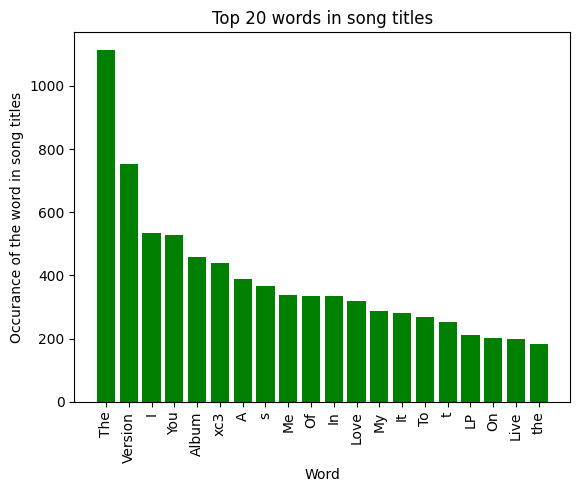

In [50]:
top_20_word_count = list(map(list, zip(*c_sort[:20])))

plt.bar(top_20_word_count[0], top_20_word_count[1], color='green')
plt.xticks(rotation=90)
plt.title('Top 20 words in song titles')
plt.xlabel('Word')
plt.ylabel('Occurance of the word in song titles')

#### Plot the words in song titles that are the hottest

Text(0, 0.5, 'Song hotness')

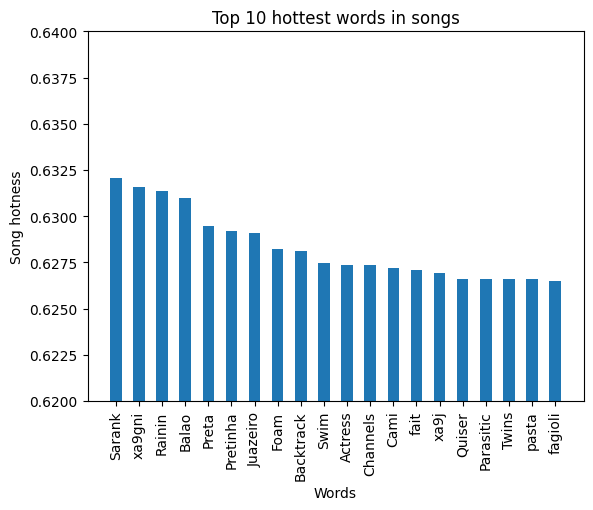

23/03/22 13:28:35 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
23/03/22 13:28:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:218)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:923)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:154)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:262)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:169)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

In [59]:
result_top_20 = list(map(list, zip(*result[:20])))
y = result_top_20[1]
x = result_top_20[0]

plt.bar(x, y, width=0.5)
plt.ylim([0.62,0.64])
plt.xticks(rotation=90)
plt.title('Top 10 hottest words in songs')
plt.xlabel('Words')
plt.ylabel('Song hotness')